In [ ]:
%pip install opendatasets
# %pip install torch torchvision torchaudio
%pip install streamlit

  Using cached opendatasets-0.1.22-py3-none-any.whl.metadata (9.2 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [36]:
import torch
import torch.nn as nn
import torch.optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

import opendatasets
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
link_of_dataset = "https://www.kaggle.com/datasets/datamunge/sign-language-mnist/data"
opendatasets.download(link_of_dataset)

Skipping, found downloaded files in "./sign-language-mnist" (use force=True to force download)


In [7]:
train_df = pd.read_csv('sign-language-mnist/sign_mnist_train.csv')
test_df = pd.read_csv('sign-language-mnist/sign_mnist_test.csv')


In [8]:
train_df.shape

(27455, 785)

torch.Size([64, 3, 224, 224]) torch.Size([64])
tensor(12)


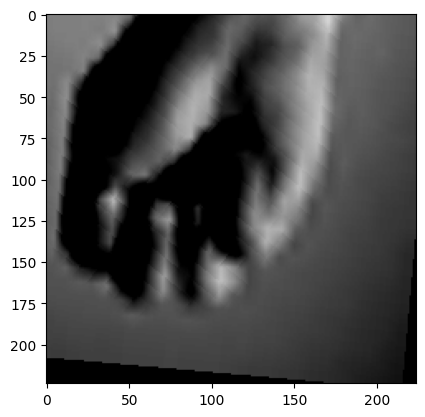

In [39]:

class SignLanguageMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        image = self.dataframe.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


# Transformations (example)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale 3 times to create 3 channels
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.RandomInvert()
])


train_dataset = SignLanguageMNISTDataset(train_df, transform=transform)
test_dataset = SignLanguageMNISTDataset(test_df, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example usage: iterate through the dataloader
for images, labels in train_loader:
    print(images.shape, labels.shape)  # Check shapes of data in loader
    image_to_show = images[0].permute(1, 2, 0)
    plt.imshow(image_to_show, cmap='gray')
    print(labels[0])
    break #only print one batch



# EDA

In [10]:
# Data Exploration
print("Train data info:\n", train_df.info())
print("\nTest data info:\n", test_df.info())

# Check for missing values
print("\nMissing values in train data:\n", train_df.isnull().sum().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
Train data info:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB

Test data info:
 None

Missing values in train data:
 0

Missing values in test data:
 0


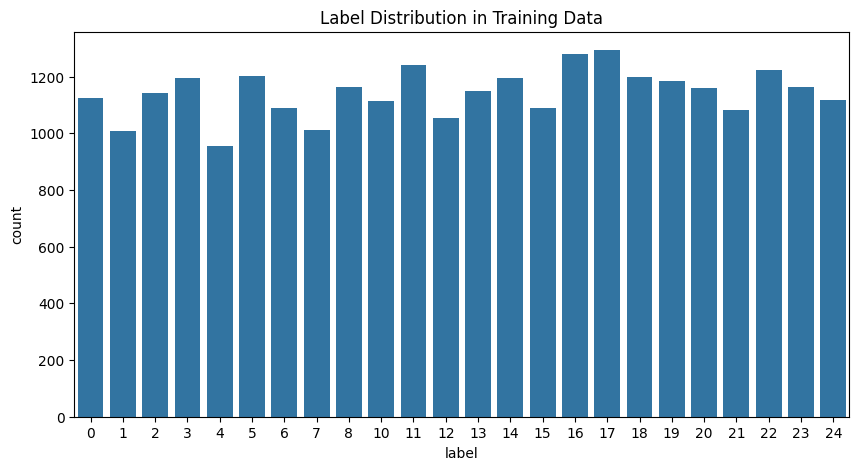

In [11]:
# Label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_df)
plt.title('Label Distribution in Training Data')
plt.show()


In [12]:
label_dir = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'K', 10:'L', 11:'M',
             12:'N', 13:'O', 14:'P', 15:'Q', 16:'R', 17:'S', 18:'T', 19:'U', 20:'V', 21:'W', 22:'X', 23:'Y', 24: 'Z'}

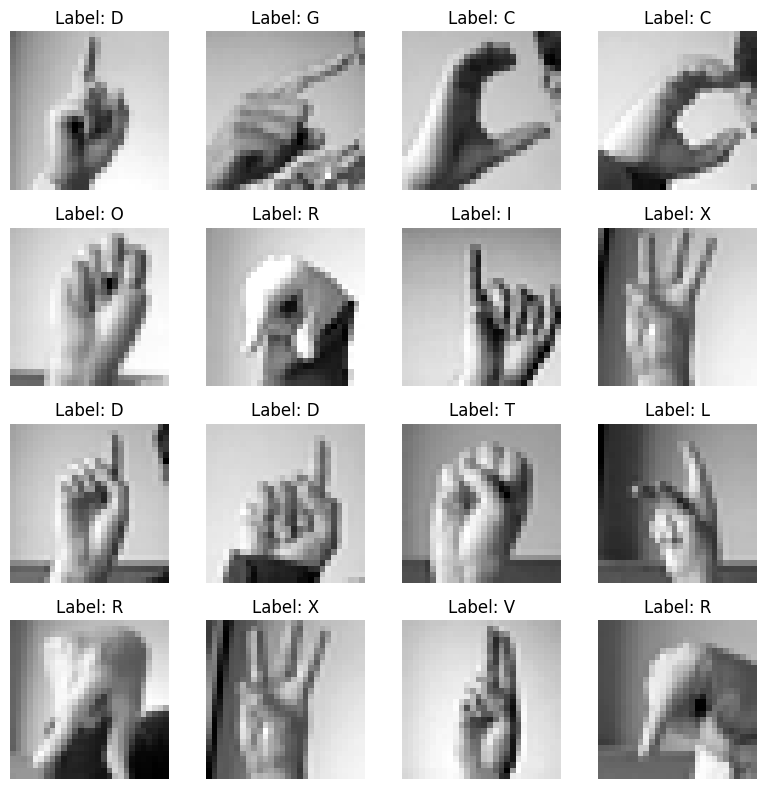

In [13]:
# Visualize some images (Sample 9 images from train set)

num_samples = 16
sample_indices = range(0, num_samples)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4
    label = train_df.iloc[idx, 0]
    image = train_df.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f"Label: {label_dir[label]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

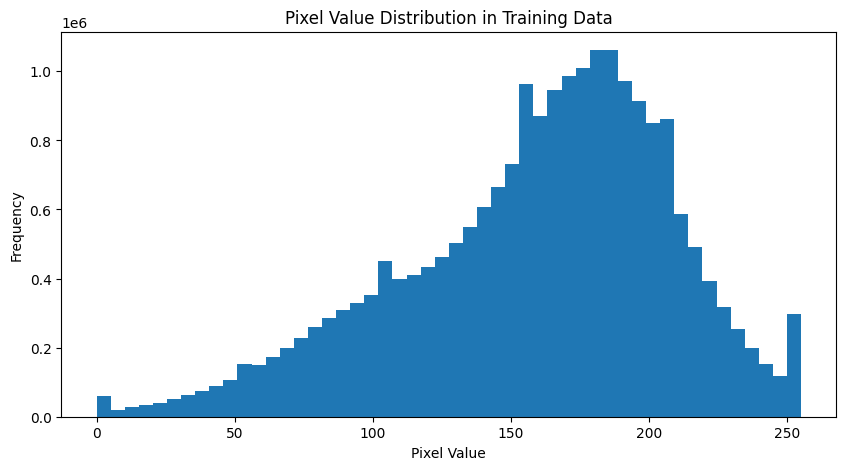

In [14]:
# Pixel value distribution (example)
plt.figure(figsize=(10, 5))
plt.hist(train_df.iloc[:, 1:].values.flatten(), bins=50)
plt.title('Pixel Value Distribution in Training Data')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Building a model Taking VGG19

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 25)  # Adjust for number of classes
model = model.to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# Default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/vgg19_experiment')

# Create a sample input tensor with 3 channels
sample_input = torch.randn(1, 3, 224, 224).to(device) # VGG19 expects input size of 224x224

# Add the model graph to TensorBoard using the sample input
writer.add_graph(vgg19, sample_input)
writer.close()

# !tensorboard --logdir=runs

In [41]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Train Class
class Train:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device, writer, epochs=10, patience=5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.writer = writer
        self.epochs = epochs
        self.patience = patience

    def run(self):
        best_val_loss = float('inf')
        epochs_no_improve = 0
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=3, factor=0.5, verbose=True)

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            progress = tqdm(enumerate(self.train_loader), total=len(self.train_loader), desc=f"Epoch {epoch+1}/{self.epochs}")
            for i, (inputs, labels) in progress:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()

                # Gradient clipping to prevent explosion
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress.set_postfix({'Loss': loss.item(), 'Accuracy': 100 * correct / total})

            epoch_loss = running_loss / len(self.train_loader)
            epoch_accuracy = 100 * correct / total

            self.writer.add_scalar('Loss/train', epoch_loss, epoch)
            self.writer.add_scalar('Accuracy/train', epoch_accuracy, epoch)

            # Validation
            val_loss, val_accuracy = self.validate()
            self.writer.add_scalar('Loss/val', val_loss, epoch)
            self.writer.add_scalar('Accuracy/val', val_accuracy, epoch)

            # Early Stopping & Model Saving
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
                print(f'Saved Best Model at Epoch {epoch+1}')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

            # Step the scheduler
            scheduler.step(val_loss)

    def validate(self):
        validator = Validate(self.model, self.val_loader, self.criterion, self.device)
        return validator.run()

# Validate Class
class Validate:
    def __init__(self, model, val_loader, criterion, device):
        self.model = model
        self.val_loader = val_loader
        self.criterion = criterion
        self.device = device

    def run(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            progress = tqdm(self.val_loader, desc='Validating')
            for inputs, labels in progress:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress.set_postfix({'Loss': loss.item(), 'Accuracy': 100 * correct / total})

        val_loss = running_loss / len(self.val_loader)
        val_accuracy = 100 * correct / total
        return val_loss, val_accuracy

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
train = Train(model, train_loader, val_loader, optimizer, criterion, device, writer, epochs=3, patience=5)
train.run()


Validating: 100%|██████████| 113/113 [01:08<00:00,  1.66it/s, Loss=1.51, Accuracy=32.1]


Saved Best Model at Epoch 1


Validating: 100%|██████████| 113/113 [01:07<00:00,  1.68it/s, Loss=1.3, Accuracy=74.3]


Saved Best Model at Epoch 2


Validating: 100%|██████████| 113/113 [01:07<00:00,  1.66it/s, Loss=0.211, Accuracy=86.7]


Saved Best Model at Epoch 3


In [44]:
torch.save(model.state_dict(), 'sign_language_vgg16_model.pth')

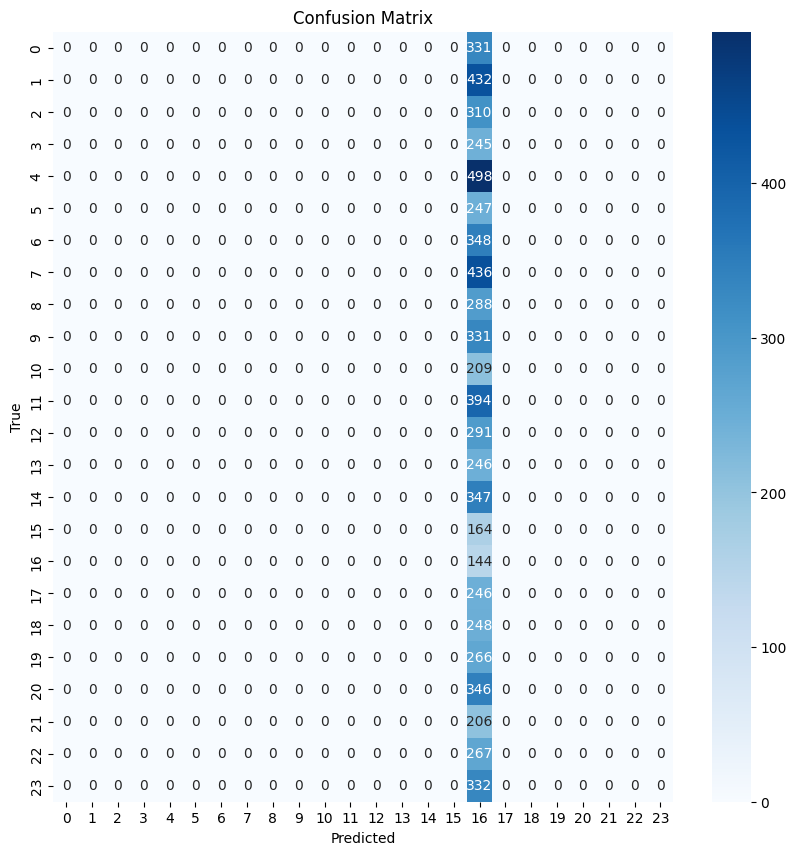

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       331
           1       0.00      0.00      0.00       432
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       245
           4       0.00      0.00      0.00       498
           5       0.00      0.00      0.00       247
           6       0.00      0.00      0.00       348
           7       0.00      0.00      0.00       436
           8       0.00      0.00      0.00       288
          10       0.00      0.00      0.00       331
          11       0.00      0.00      0.00       209
          12       0.00      0.00      0.00       394
          13       0.00      0.00      0.00       291
          14       0.00      0.00      0.00       246
          15       0.00      0.00      0.00       347
          16       0.00      0.00      0.00       164
          17       0.02      1.00      0.04       144
          18       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# model.load_state_dict(torch.load('sign_language_vgg19_model.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('sign_language_vgg19_model.pth'))


# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())
    return np.array(y_true), np.array(y_pred)


y_true, y_pred = get_predictions(model, test_loader, device)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))


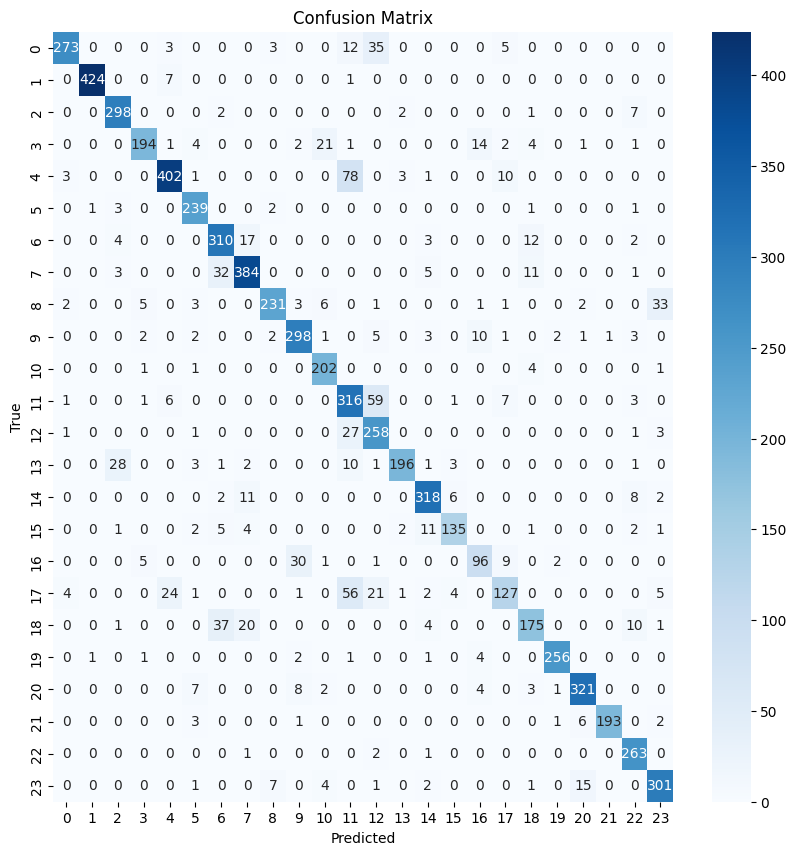

              precision    recall  f1-score   support

           0       0.96      0.82      0.89       331
           1       1.00      0.98      0.99       432
           2       0.88      0.96      0.92       310
           3       0.93      0.79      0.85       245
           4       0.91      0.81      0.85       498
           5       0.89      0.97      0.93       247
           6       0.80      0.89      0.84       348
           7       0.87      0.88      0.88       436
           8       0.94      0.80      0.87       288
          10       0.86      0.90      0.88       331
          11       0.85      0.97      0.91       209
          12       0.63      0.80      0.71       394
          13       0.67      0.89      0.76       291
          14       0.96      0.80      0.87       246
          15       0.90      0.92      0.91       347
          16       0.91      0.82      0.86       164
          17       0.74      0.67      0.70       144
          18       0.78    

In [45]:
# model.load_state_dict(torch.load('sign_language_vgg16_model.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('sign_language_vgg16_model.pth'))


# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())
    return np.array(y_true), np.array(y_pred)


y_true, y_pred = get_predictions(model, test_loader, device)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))


In [ ]:
# prompt: I want to deploy this model to streamlit, give me pepeline code to process data and detect the signs

import streamlit as st
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load the trained model
model = models.vgg19(pretrained=False)
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 25)
model.load_state_dict(torch.load('sign_language_vgg19_model.pth', map_location=torch.device('cpu')))
model.eval()


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the labels
label_dir = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'K', 10:'L', 11:'M',
             12:'N', 13:'O', 14:'P', 15:'Q', 16:'R', 17:'S', 18:'T', 19:'U', 20:'V', 21:'W', 22:'X', 23:'Y', 24: 'Z'}


def predict_sign(image):
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Streamlit app
st.title("Sign Language MNIST Classifier")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('L') # Convert to grayscale
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    prediction = predict_sign(image)
    st.write(f"Predicted sign: {label_dir[prediction]}")
